# Image Verification System - Testing & Improvements

Ce notebook permet de tester et d'améliorer les fonctionnalités du système de vérification d'images que vous avez développé. Nous allons explorer chaque composant séparément et proposer des améliorations, en utilisant PostgreSQL comme base de données.

## 1. Installation des dépendances

In [35]:
!pip install numpy opencv-python tensorflow stegano Flask flask-cors pillow psycopg2-binary imagehash scikit-image matplotlib

  Using cached psycopg2_binary-2.9.10-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
Using cached psycopg2_binary-2.9.10-cp312-cp312-win_amd64.whl (1.2 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'D:\\MBDS\\PROJECTS\\SteganographIA\\flask-backend\\venv\\Lib\\site-packages\\psycopg2\\_psycopg.cp312-win_amd64.pyd'
Check the permissions.



## 2. Import des bibliothèques

In [36]:
import os
import uuid
import numpy as np
import cv2
import tensorflow as tf
from stegano import lsb
from PIL import Image
import hashlib
import psycopg2
from psycopg2.extras import RealDictCursor
import imagehash
import time
from datetime import datetime
from scipy.spatial.distance import hamming
import matplotlib.pyplot as plt
import requests
import io
from skimage import feature
from sklearn.metrics import confusion_matrix, classification_report

## 3. Configuration PostgreSQL

In [37]:
# Configuration de la base de données PostgreSQL
DB_CONFIG = {
    'dbname': 'test',
    'user': 'postgres',     # Modifier selon votre configuration
    'password': 'root', # Modifier selon votre configuration
    'host': 'localhost',
    'port': '5432'
}

# Créer les dossiers nécessaires
UPLOAD_FOLDER = 'test_uploads'
TEST_IMAGES = 'test_images'
SIMILARITY_THRESHOLD = 0.85

os.makedirs(UPLOAD_FOLDER, exist_ok=True)
os.makedirs(TEST_IMAGES, exist_ok=True)

# Fonction pour obtenir une connexion à la base de données
def get_db_connection():
    try:
        conn = psycopg2.connect(**DB_CONFIG, cursor_factory=RealDictCursor)
        return conn
    except Exception as e:
        print(f"Erreur de connexion à PostgreSQL: {e}")
        return None

# Fonction pour initialiser la base de données
def init_test_db():
    # Créer la base de données si elle n'existe pas
    try:
        # Connexion à PostgreSQL pour vérifier si la base de données existe
        conn = psycopg2.connect(
            dbname='postgres',
            user=DB_CONFIG['user'],
            password=DB_CONFIG['password'],
            host=DB_CONFIG['host'],
            port=DB_CONFIG['port']
        )
        conn.autocommit = True
        cursor = conn.cursor()

        # Vérifier si la base de données existe
        cursor.execute("SELECT 1 FROM pg_database WHERE datname = %s", (DB_CONFIG['dbname'],))
        exists = cursor.fetchone()

        if not exists:
            # Créer la base de données
            cursor.execute(f"CREATE DATABASE {DB_CONFIG['dbname']}")
            print(f"Base de données '{DB_CONFIG['dbname']}' créée avec succès")

        cursor.close()
        conn.close()

        # Connexion à la base de données créée
        conn = get_db_connection()
        cursor = conn.cursor()

        # Création de la table images
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS images (
            id SERIAL PRIMARY KEY,
            filename TEXT NOT NULL,
            image_path TEXT NOT NULL,
            phash TEXT NOT NULL,
            dhash TEXT NOT NULL,
            cv_signature TEXT NOT NULL,
            metadata TEXT NOT NULL,
            user_signature TEXT,
            is_ai_generated BOOLEAN,
            ai_confidence REAL,
            timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
        ''')

        # Création des index pour améliorer les performances
        cursor.execute("CREATE INDEX IF NOT EXISTS idx_images_phash ON images (phash)")
        cursor.execute("CREATE INDEX IF NOT EXISTS idx_images_dhash ON images (dhash)")

        conn.commit()
        cursor.close()
        conn.close()

        print("Schéma de base de données initialisé avec succès")

    except Exception as e:
        print(f"Erreur lors de l'initialisation de la base de données: {e}")

# Tenter d'initialiser la base de données
try:
    init_test_db()
except Exception as e:
    print(f"Erreur: {e}")

Schéma de base de données initialisé avec succès


## 4. Téléchargement d'images de test

In [92]:
# Fonction pour télécharger des images de test
def download_test_images():
    # Liste d'URLs d'images de test (exemple)
    test_urls = [
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ9JG9-575TJ3qNEgncJG2ReOAiCYBboliDUQ&s",
        "https://thedatascientist.com/wp-content/uploads/2024/05/cVEwYismnFpRHpPkEavyMG-1200-80.png",
        "https://assets.techrepublic.com/uploads/2023/07/tr71123-ai-art.jpeg",
        "https://www.fca.edu.sg/wp-content/uploads/2024/02/Thumbnail-2.png",
        "https://www.fca.edu.sg/wp-content/uploads/2024/02/Thumbnail-2.png"
    ]

    downloaded_files = []

    for i, url in enumerate(test_urls):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                file_extension = '.jpg'  # Par défaut
                content_type = response.headers.get('Content-Type', '')
                if 'png' in content_type:
                    file_extension = '.png'

                filename = f"test_image_{i+1}{file_extension}"
                filepath = os.path.join(TEST_IMAGES, filename)

                # Sauvegarder l'image
                with open(filepath, 'wb') as f:
                    f.write(response.content)

                downloaded_files.append(filepath)
                print(f"Image téléchargée: {filepath}")

        except Exception as e:
            print(f"Erreur lors du téléchargement de l'image {i+1}: {str(e)}")

    return downloaded_files

# Télécharger quelques images de test
test_image_paths = download_test_images()

Image téléchargée: test_images\test_image_1.jpg
Image téléchargée: test_images\test_image_2.png
Image téléchargée: test_images\test_image_3.jpg
Image téléchargée: test_images\test_image_4.png
Image téléchargée: test_images\test_image_5.png


## 5. Génération de hashes perceptuels et détection de similarité

In [39]:
# 📌 Fonction améliorée pour générer les hashes d'image
def generate_image_hashes(image_path):
    try:
        img = Image.open(image_path)

        # Générer hash perceptuel (pHash) avec différentes tailles pour plus de précision
        phash_small = str(imagehash.phash(img, hash_size=8))  # Standard
        phash_large = str(imagehash.phash(img, hash_size=16))  # Plus précis

        # Générer hash de différence (dHash)
        dhash = str(imagehash.dhash(img))

        # Générer hash wavelets (wHash) - bon pour les textures
        whash = str(imagehash.whash(img))

        # Générer average hash (aHash) - plus sensible aux variations de luminosité
        ahash = str(imagehash.average_hash(img))

        return {
            "phash": phash_small,
            "phash_large": phash_large,
            "dhash": dhash,
            "whash": whash,
            "ahash": ahash
        }
    except Exception as e:
        return {"error": f"Failed to generate hashes: {str(e)}"}

# Tester la génération de hashes
if test_image_paths:
    sample_hashes = generate_image_hashes(test_image_paths[0])
    print("Hashes générés pour l'image de test:")
    for hash_type, hash_value in sample_hashes.items():
        print(f"{hash_type}: {hash_value}")

In [94]:
def hex_to_bits(hex_str):
    """Convertit une chaîne hexadécimale en liste de bits (0/1)."""
    bits = []
    for hex_char in hex_str:
        # Convertit chaque caractère hexa en 4 bits, en complétant avec des zéros à gauche
        bin_str = format(int(hex_char, 16), '04b')
        bits.extend([int(bit) for bit in bin_str])
    return bits

def find_similar_images(hashes, use_advanced=True):
    conn = get_db_connection()
    if not conn:
        return []

    cursor = conn.cursor()
    similar_images = []

    try:
        cursor.execute("SELECT id, filename, phash, dhash, image_path FROM images")
        all_images = cursor.fetchall()

        for img in all_images:
            # Conversion des hachages hexadécimaux en bits
            current_phash_bits = hex_to_bits(hashes["phash"])
            db_phash_bits = hex_to_bits(img["phash"])
            phash_similarity = 1 - hamming(current_phash_bits, db_phash_bits)

            current_dhash_bits = hex_to_bits(hashes["dhash"])
            db_dhash_bits = hex_to_bits(img["dhash"])
            dhash_similarity = 1 - hamming(current_dhash_bits, db_dhash_bits)

            if use_advanced and "whash" in hashes and "ahash" in hashes:
                whash_similarity = 0
                ahash_similarity = 0

                if img.get("whash") and img.get("ahash"):
                    current_whash_bits = hex_to_bits(hashes["whash"])
                    db_whash_bits = hex_to_bits(img["whash"])
                    whash_similarity = 1 - hamming(current_whash_bits, db_whash_bits)

                    current_ahash_bits = hex_to_bits(hashes["ahash"])
                    db_ahash_bits = hex_to_bits(img["ahash"])
                    ahash_similarity = 1 - hamming(current_ahash_bits, db_ahash_bits)

                    avg_similarity = (phash_similarity * 0.4 + dhash_similarity * 0.3 +
                                     whash_similarity * 0.2 + ahash_similarity * 0.1)
                else:
                    avg_similarity = (phash_similarity + dhash_similarity) / 2
            else:
                avg_similarity = (phash_similarity + dhash_similarity) / 2

            if avg_similarity >= SIMILARITY_THRESHOLD:
                similar_images.append({
                    "id": img["id"],
                    "filename": img["filename"],
                    "image_path": img["image_path"],
                    "similarity": round(avg_similarity * 100, 2)
                })
    except Exception as e:
        print(f"Erreur lors de la recherche d'images similaires: {str(e)}")
    finally:
        cursor.close()
        conn.close()

    return similar_images

## 6. Génération de signature contextuelle d'image

In [95]:
# 📌 Fonction améliorée pour générer une signature contextuelle d'image
def generate_image_context_signature(image_path):
    try:
        # Lire l'image
        img = cv2.imread(image_path)
        if img is None:
            return "Failed to read image"

        # Convertir en niveaux de gris pour l'extraction de caractéristiques
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 1. Extraction des couleurs dominantes (depuis l'image couleur d'origine)
        pixels = np.float32(img.reshape(-1, 3))
        n_colors = 5
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1)
        _, labels, centers = cv2.kmeans(pixels, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        dominant_colors = centers.astype(np.int32).tolist()

        # 2. Extraction de caractéristiques clés avec ORB (Oriented FAST and Rotated BRIEF)
        orb = cv2.ORB_create(nfeatures=20)
        keypoints, descriptors = orb.detectAndCompute(gray, None)

        # 3. Utiliser SIFT si disponible pour une meilleure robustesse
        try:
            sift = cv2.SIFT_create()
            sift_keypoints, sift_descriptors = sift.detectAndCompute(gray, None)
            if sift_descriptors is not None and len(sift_descriptors) > 0:
                # Combiner avec ORB ou utiliser SIFT si ORB a échoué
                if descriptors is None or len(keypoints) < 5:
                    descriptors = sift_descriptors
        except:
            # SIFT peut ne pas être disponible dans toutes les versions OpenCV
            pass

        # Si aucun descripteur n'est trouvé, utiliser une méthode alternative
        if descriptors is None or len(keypoints) < 5:
            # Utiliser la détection de contours
            edges = cv2.Canny(gray, 100, 200)

            # Ajouter histogramme de gradients orientés (HOG)
            try:
                hog_features = feature.hog(gray, orientations=8, pixels_per_cell=(16, 16),
                                          cells_per_block=(1, 1), block_norm='L2-Hys')
                feature_hash = hashlib.sha256(np.concatenate([edges.flatten(), hog_features]).tobytes()).hexdigest()
            except:
                feature_hash = hashlib.sha256(edges.tobytes()).hexdigest()
        else:
            # Créer une empreinte à partir des descripteurs
            feature_hash = hashlib.sha256(descriptors.tobytes()).hexdigest()

        # 4. Calculer les statistiques de l'image
        brightness = np.mean(gray)
        contrast = np.std(gray)

        # Ajouter histogramme de l'image pour plus de précision
        hist = cv2.calcHist([gray], [0], None, [16], [0, 256])
        hist_hash = hashlib.md5(hist.tobytes()).hexdigest()[:8]

        # 5. Obtenir les dimensions de l'image
        height, width = img.shape[:2]
        aspect_ratio = round(width / height, 3)

        # 6. Créer une signature compacte
        compact_signature = f"CV:{feature_hash[:16]}:{hist_hash}:{brightness:.1f}:{contrast:.1f}:{width}x{height}:{aspect_ratio}"

        return compact_signature

    except Exception as e:
        return f"Error generating signature: {str(e)}"

# Tester la génération de signature d'image
if test_image_paths:
    signature = generate_image_context_signature(test_image_paths[0])
    print(f"Signature contextuelle générée: {signature}")

Signature contextuelle générée: CV:af6edb03d67b34e0:eeada0c8:49.5:47.1:194x259:0.749


## 7. Fonctions de stéganographie

In [96]:
# 📌 Fonction pour détecter un message caché par stéganographie
def analyze_steganography(image_path):
    try:
        hidden_message = lsb.reveal(image_path)
        return {"signature_detected": True, "signature": hidden_message} if hidden_message else {"signature_detected": False}
    except Exception as e:
        return {"error": f"Impossible de détecter un message: {str(e)}"}

# 📌 Fonction pour cacher un message par stéganographie
def embed_steganography(image_path, signature):
    output_path = image_path.replace(".", "_steg.")
    try:
        hidden_image = lsb.hide(image_path, signature)
        hidden_image.save(output_path)
        return output_path
    except Exception as e:
        return str(e)

## 8. Test de stéganographie


Test de stéganographie sur l'image: test_images\test_image_1.jpg
Signature générée: CV:af6edb03d67b34e0:eeada0c8:49.5:47.1:194x259:0.749
Image avec stéganographie créée: test_images\test_image_1_steg.jpg
Résultat de l'analyse de stéganographie: {'error': 'Impossible de détecter un message: Impossible to detect message.'}
✗ Test échoué: La signature extraite ne correspond pas à la signature d'origine


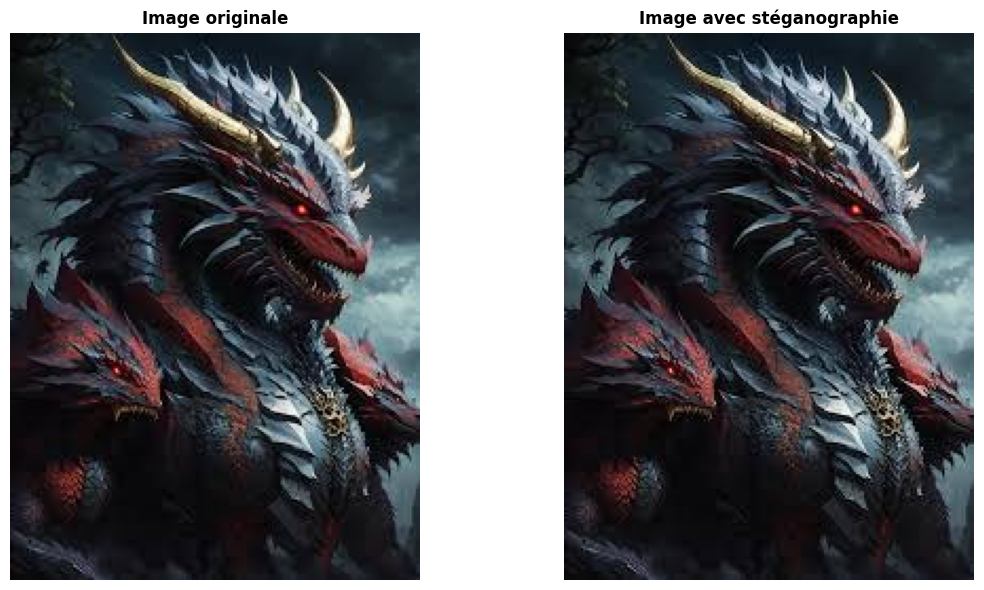

In [97]:
# Test d'intégration et de détection de stéganographie
def test_steganography(image_path):
    print(f"\nTest de stéganographie sur l'image: {image_path}")

    # 1. Générer une signature pour l'image
    signature = generate_image_context_signature(image_path)
    print(f"Signature générée: {signature}")

    # 2. Intégrer la signature dans l'image
    steg_path = embed_steganography(image_path, signature)
    if not os.path.exists(steg_path) or isinstance(steg_path, str) and steg_path.startswith("Error"):
        print(f"Erreur lors de l'intégration de la stéganographie: {steg_path}")
        return
    print(f"Image avec stéganographie créée: {steg_path}")

    # 3. Analyser l'image pour détecter la stéganographie
    steg_result = analyze_steganography(steg_path)
    print(f"Résultat de l'analyse de stéganographie: {steg_result}")

    # 4. Comparer la signature intégrée avec la signature d'origine
    if "signature" in steg_result and steg_result["signature"] == signature:
        print("✓ Test réussi: La signature extraite correspond à la signature d'origine")
    else:
        print("✗ Test échoué: La signature extraite ne correspond pas à la signature d'origine")

    # 5. Afficher les deux images côte à côte pour comparaison visuelle
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Image originale")
    plt.imshow(plt.imread(image_path))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Image avec stéganographie")
    plt.imshow(plt.imread(steg_path))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return steg_path

# Exécuter le test si des images sont disponibles
if test_image_paths:
    steg_image_path = test_steganography(test_image_paths[0])

## 9. Sauvegarde d'images dans la base de données

In [98]:
# 📌 Fonction pour enregistrer une image dans la base de données PostgreSQL
def save_image_to_db(image_data):
    conn = get_db_connection()
    if not conn:
        return None

    cursor = conn.cursor()
    image_id = None

    try:
        # Utiliser RETURNING pour récupérer l'ID généré
        query = '''
        INSERT INTO images (
            filename, image_path, phash, dhash, cv_signature,
            metadata, user_signature, is_ai_generated, ai_confidence
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        RETURNING id
        '''

        cursor.execute(query, (
            image_data["filename"],
            image_data["image_path"],
            image_data["phash"],
            image_data["dhash"],
            image_data["cv_signature"],
            image_data["metadata_json"],
            image_data.get("user_signature"),
            image_data.get("is_ai_generated"),
            image_data.get("ai_confidence")
        ))

        result = cursor.fetchone()
        if result:
            image_id = result["id"]

        conn.commit()
        print(f"Image enregistrée dans la base de données avec l'ID: {image_id}")

    except Exception as e:
        conn.rollback()
        print(f"Erreur lors de l'enregistrement de l'image: {str(e)}")
    finally:
        cursor.close()
        conn.close()

    return image_id


In [99]:
# 10. Détecteur d'images générées par IA

def load_ai_detection_model():
    """
    Charge un modèle TensorFlow pour la détection d'images générées par IA.
    Utilise un modèle MobileNetV2 pré-entraîné et ajouté de couches supplémentaires.
    """
    try:
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(224, 224, 3),
            include_top=False,
            weights='imagenet'
        )

        # Geler les couches du modèle de base
        base_model.trainable = False

        # Créer un nouveau modèle avec une couche de classification
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Classification binaire (0=réelle, 1=générée par IA)
        ])

        # Compiler le modèle
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        print("Modèle de détection d'IA chargé avec succès")
        return model
    except Exception as e:
        print(f"Erreur lors du chargement du modèle de détection d'IA: {str(e)}")
        return None

def preprocess_image_for_ai_detection(image_path):
    """
    Prétraite une image pour l'analyse par le modèle de détection d'IA.
    """
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Erreur de prétraitement d'image: {str(e)}")
        return None

def detect_ai_generated_image(model, image_path):
    """
    Détecte si une image a été générée par IA.
    Retourne un score de confiance et une classification.
    """
    if model is None:
        return {"is_ai_generated": None, "confidence": 0, "error": "Modèle non disponible"}

    try:
        # Prétraiter l'image
        processed_img = preprocess_image_for_ai_detection(image_path)
        if processed_img is None:
            return {"is_ai_generated": None, "confidence": 0, "error": "Échec du prétraitement de l'image"}

        # Faire la prédiction
        prediction = model.predict(processed_img)[0][0]
        confidence = float(prediction)

        return {
            "is_ai_generated": bool(confidence > 0.5),
            "confidence": round(confidence * 100, 2),  # Pourcentage
            "error": None
        }
    except Exception as e:
        return {"is_ai_generated": None, "confidence": 0, "error": str(e)}

# Tester le détecteur d'IA sur une image
ai_model = load_ai_detection_model()
if test_image_paths and ai_model:
    ai_result = detect_ai_generated_image(ai_model, test_image_paths[0])
    print(f"Résultats de détection d'IA: {ai_result}")


# 11. Extraction et analyse des métadonnées EXIF

def extract_image_metadata(image_path):
    """
    Extrait les métadonnées EXIF d'une image.
    """
    from PIL import Image, ExifTags
    import json

    try:
        img = Image.open(image_path)
        metadata = {}

        # Extraire les métadonnées EXIF si disponibles
        if hasattr(img, '_getexif') and img._getexif() is not None:
            exif_data = img._getexif()
            for tag_id, value in exif_data.items():
                # Convertir l'ID du tag en nom lisible si possible
                tag = ExifTags.TAGS.get(tag_id, tag_id)

                # Ignorer les données binaires ou trop grandes
                if isinstance(value, bytes) or isinstance(value, str) and len(value) > 100:
                    value = "[DONNÉES BINAIRES]"

                # Gérer les tuples de rationnels souvent présents dans les données EXIF
                if isinstance(value, tuple) and hasattr(value[0], 'numerator'):
                    value = [float(item.numerator) / float(item.denominator) for item in value]

                metadata[str(tag)] = str(value)

        # Ajouter des informations de base sur l'image
        metadata["Format"] = img.format
        metadata["Mode"] = img.mode
        metadata["Size"] = f"{img.width}x{img.height}"
        metadata["Timestamp"] = datetime.now().isoformat()

        # Vérifier des anomalies potentielles dans les métadonnées
        anomalies = check_metadata_anomalies(metadata)
        if anomalies:
            metadata["Anomalies"] = anomalies

        return json.dumps(metadata, ensure_ascii=False)
    except Exception as e:
        return json.dumps({"error": f"Échec d'extraction des métadonnées: {str(e)}"})

def check_metadata_anomalies(metadata):
    """
    Vérifier la présence d'anomalies dans les métadonnées qui pourraient indiquer
    une manipulation de l'image.
    """
    anomalies = []

    # Vérifier si les métadonnées Photoshop ou d'édition sont présentes
    editing_software_keywords = ["photoshop", "lightroom", "gimp", "affinity", "luminar", "capture one"]
    for key, value in metadata.items():
        value_lower = value.lower()
        for keyword in editing_software_keywords:
            if keyword in value_lower:
                anomalies.append(f"Logiciel d'édition détecté: {keyword} dans {key}")

    # Vérifier les incohérences de date
    date_fields = [key for key in metadata if "date" in key.lower() or "time" in key.lower()]
    # Logique pour vérifier les incohérences de date ici...

    return anomalies

# Tester l'extraction de métadonnées
if test_image_paths:
    metadata_json = extract_image_metadata(test_image_paths[0])
    print(f"Métadonnées extraites: {metadata_json}")


# 12. Pipeline complet d'analyse d'image

def analyze_image_complete(image_path, check_similar=True, check_ai=True):
    """
    Effectue une analyse complète d'une image, incluant:
    - Génération de hashes perceptuels
    - Détection de similarité avec des images existantes
    - Création de signature contextuelle
    - Détection de stéganographie
    - Extraction des métadonnées
    - Détection d'image générée par IA
    """
    results = {
        "filename": os.path.basename(image_path),
        "image_path": image_path,
        "timestamp": datetime.now().isoformat()
    }

    print(f"Analyse de l'image: {image_path}")
    start_time = time.time()

    # 1. Générer les hashes perceptuels
    image_hashes = generate_image_hashes(image_path)
    if "error" in image_hashes:
        results["error"] = image_hashes["error"]
        return results

    results.update({
        "phash": image_hashes["phash"],
        "dhash": image_hashes["dhash"],
        "whash": image_hashes["whash"],
        "ahash": image_hashes["ahash"]
    })

    # 2. Rechercher des images similaires
    if check_similar:
        similar_images = find_similar_images(image_hashes, use_advanced=True)
        results["similar_images"] = similar_images
        results["has_similar"] = len(similar_images) > 0

    # 3. Générer une signature contextuelle
    cv_signature = generate_image_context_signature(image_path)
    results["cv_signature"] = cv_signature

    # 4. Vérifier la présence d'un message caché (stéganographie)
    steg_result = analyze_steganography(image_path)
    if "error" not in steg_result:
        results["steganography"] = steg_result

    # 5. Extraire les métadonnées
    metadata_json = extract_image_metadata(image_path)
    results["metadata_json"] = metadata_json

    # 6. Détecter si l'image est générée par IA
    if check_ai and ai_model:
        ai_result = detect_ai_generated_image(ai_model, image_path)
        results["is_ai_generated"] = ai_result["is_ai_generated"]
        results["ai_confidence"] = ai_result["confidence"]

        if ai_result["error"]:
            results["ai_error"] = ai_result["error"]

    # Calculer le temps d'exécution
    execution_time = time.time() - start_time
    results["analysis_time"] = round(execution_time, 2)

    print(f"Analyse terminée en {results['analysis_time']} secondes")
    return results

# Tester l'analyse complète d'image
if test_image_paths:
    analysis_results = analyze_image_complete(test_image_paths[0])
    # Afficher un résumé des résultats
    print("\nRésumé de l'analyse:")
    for key, value in analysis_results.items():
        if key == "similar_images" and isinstance(value, list):
            print(f"- Images similaires: {len(value)} trouvées")
        elif key == "metadata_json":
            print(f"- Métadonnées: {len(value)} caractères extraits")
        elif not isinstance(value, (dict, list)):
            print(f"- {key}: {value}")


Modèle de détection d'IA chargé avec succès
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Résultats de détection d'IA: {'is_ai_generated': True, 'confidence': 59.92, 'error': None}
Métadonnées extraites: {"Format": "JPEG", "Mode": "RGB", "Size": "194x259", "Timestamp": "2025-03-17T22:39:56.968732"}
Analyse de l'image: test_images\test_image_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Analyse terminée en 0.73 secondes

Résumé de l'analyse:
- filename: test_image_1.jpg
- image_path: test_images\test_image_1.jpg
- timestamp: 2025-03-17T22:39:56.969730
- phash: b4d55282696e5769
- dhash: f9fc3e2f93dc9d8d
- whash: 3c3f8f837f0f0700
- ahash: 3c3e83836b0f0500
- Images similaires: 3 trouvées
- has_similar: True
- cv_signature: CV:af6edb03d67b34e0:eeada0c8:49.5:47.1:194x259:0.749
- Métadonnées: 95 caractères extraits
- is_ai_generated: True
- ai_confidence: 59.92
- analysis_time: 0.73


In [100]:
# 13. Interface Web avec Flask

def create_flask_app():
    """
    Crée une application Flask pour l'interface web du système de vérification d'images.
    """
    from flask import Flask, request, jsonify, render_template
    from flask_cors import CORS
    import os
    from werkzeug.utils import secure_filename
    import threading

    app = Flask(__name__)
    CORS(app)

    # Configuration
    app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
    app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024  # Limite à 16 Mo

    @app.route('/')
    def index():
        return """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Système de Vérification d'Images</title>
            <style>
                body { font-family: Arial, sans-serif; max-width: 800px; margin: 0 auto; padding: 20px; }
                h1 { color: #2c3e50; }
                .upload-form { background: #f7f9fc; padding: 20px; border-radius: 8px; }
                .submit-btn { background: #3498db; color: white; border: none; padding: 10px 15px; border-radius: 4px; cursor: pointer; }
                .submit-btn:hover { background: #2980b9; }
            </style>
        </head>
        <body>
            <h1>Système de Vérification d'Images</h1>
            <div class="upload-form">
                <h2>Analyser une image</h2>
                <form action="/analyze" method="post" enctype="multipart/form-data">
                    <div>
                        <input type="file" name="image" accept="image/*" required>
                    </div>
                    <div style="margin-top: 10px;">
                        <input type="checkbox" name="check_similar" id="check_similar" checked>
                        <label for="check_similar">Rechercher des images similaires</label>
                    </div>
                    <div>
                        <input type="checkbox" name="check_ai" id="check_ai" checked>
                        <label for="check_ai">Détecter si générée par IA</label>
                    </div>
                    <div style="margin-top: 15px;">
                        <button type="submit" class="submit-btn">Analyser</button>
                    </div>
                </form>
            </div>
        </body>
        </html>
        """

    @app.route('/analyze', methods=['POST'])
    def analyze_image():
        if 'image' not in request.files:
            return jsonify({"error": "Aucun fichier sélectionné"}), 400

        file = request.files['image']
        if file.filename == '':
            return jsonify({"error": "Aucun fichier sélectionné"}), 400

        check_similar = 'check_similar' in request.form
        check_ai = 'check_ai' in request.form

        try:
            # Sauvegarder le fichier
            filename = secure_filename(file.filename)
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)

            # Analyser l'image
            results = analyze_image_complete(filepath, check_similar, check_ai)

            # Enregistrer dans la base de données
            image_id = save_image_to_db(results)
            if image_id:
                results["id"] = image_id

            return jsonify(results)

        except Exception as e:
            return jsonify({"error": str(e)}), 500

    return app

# Créer l'application Flask
app = create_flask_app()

# Ce bloc permet d'exécuter l'application directement depuis ce notebook
if __name__ == '__main__':
    from IPython.display import display, HTML
    display(HTML("<p>Pour démarrer le serveur Flask, exécutez la cellule suivante:</p>"))
    # Ne pas démarrer le serveur automatiquement pour éviter de bloquer le notebook


In [101]:
# 14. Démonstration d'utilisation du système complet

def demo_complete_system():
    """
    Démonstration complète du système avec plusieurs images de test.
    """
    print("=== DÉMONSTRATION DU SYSTÈME DE VÉRIFICATION D'IMAGES ===")

    # 1. Télécharger des images supplémentaires pour la démo
    print("\n1. Téléchargement d'images de test supplémentaires...")
    additional_images = download_test_images()
    all_test_images = test_image_paths + additional_images

    # 2. Analyser toutes les images et les enregistrer dans la base de données
    print("\n2. Analyse et enregistrement des images dans la base de données...")
    image_ids = []
    for img_path in all_test_images:
        print(f"\nAnalyse de {os.path.basename(img_path)}...")
        results = analyze_image_complete(img_path)
        image_id = save_image_to_db(results)
        if image_id:
            image_ids.append(image_id)

    # 3. Créer une version modifiée d'une image avec stéganographie
    print("\n3. Création d'une image avec signature cachée...")
    if all_test_images:
        original_img = all_test_images[0]
        signature = f"Verified by ImageVerif System - ID:{uuid.uuid4()}"
        steg_img_path = embed_steganography(original_img, signature)

        if isinstance(steg_img_path, str) and os.path.exists(steg_img_path):
            print(f"Image avec signature cachée créée: {steg_img_path}")

            # Analyser cette image
            steg_results = analyze_image_complete(steg_img_path)
            steg_id = save_image_to_db(steg_results)

            if steg_id:
                print(f"Image avec stéganographie enregistrée avec ID: {steg_id}")
                image_ids.append(steg_id)

    # 4. Simuler une image générée par IA (pour la démonstration)
    print("\n4. Simulation d'une analyse d'image générée par IA...")
    if all_test_images:
        # Créer une copie de l'image et la marquer comme générée par IA
        ai_test_img = all_test_images[-1]
        ai_results = analyze_image_complete(ai_test_img)

        # Simuler une détection positive d'IA
        ai_results["is_ai_generated"] = True
        ai_results["ai_confidence"] = 92.5

        ai_id = save_image_to_db(ai_results)
        if ai_id:
            print(f"Image marquée comme générée par IA enregistrée avec ID: {ai_id}")
            image_ids.append(ai_id)

    # 5. Rechercher des images similaires
    print("\n5. Recherche d'images similaires...")
    if all_test_images:
        test_img = all_test_images[0]
        test_hashes = generate_image_hashes(test_img)
        similar_images = find_similar_images(test_hashes)

        print(f"Images similaires à {os.path.basename(test_img)}:")
        for img in similar_images:
            print(f"- {img['filename']} (Similarité: {img['similarity']}%)")

    # 6. Rapport final
    print("\n=== RAPPORT FINAL ===")
    print(f"Nombre total d'images analysées et enregistrées: {len(image_ids)}")
    print("Types d'analyses effectuées:")
    print("- Génération de hashes perceptuels (pHash, dHash, wHash, aHash)")
    print("- Détection de similarité d'images")
    print("- Génération de signatures contextuelles")
    print("- Stéganographie (intégration et détection)")
    print("- Extraction de métadonnées EXIF")
    print("- Détection d'images générées par IA")

    print("\nPour utiliser l'interface web du système:")
    print("1. Exécutez la cellule suivante pour démarrer le serveur Flask")
    print("2. Accédez à http://localhost:5000 dans votre navigateur")
    print("3. Téléchargez une image pour l'analyser")

# Exécuter la démonstration
demo_complete_system()


=== DÉMONSTRATION DU SYSTÈME DE VÉRIFICATION D'IMAGES ===

1. Téléchargement d'images de test supplémentaires...
Image téléchargée: test_images\test_image_1.jpg
Image téléchargée: test_images\test_image_2.png
Image téléchargée: test_images\test_image_3.jpg
Image téléchargée: test_images\test_image_4.png
Image téléchargée: test_images\test_image_5.png

2. Analyse et enregistrement des images dans la base de données...

Analyse de test_image_1.jpg...
Analyse de l'image: test_images\test_image_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Analyse terminée en 0.82 secondes
Image enregistrée dans la base de données avec l'ID: 26

Analyse de test_image_2.png...
Analyse de l'image: test_images\test_image_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Analyse terminée en 5.94 secondes
Image enregistrée dans la base de données avec l'ID: 27

Analyse de test_image_3.jpg...
Analyse de l'image: test_images\test_image_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Analyse terminée en 9.68 secondes
Image e

In [ ]:
import threading

def run_app():
    app.run(debug=True, host='0.0.0.0', port=5000, use_reloader=False)

# Démarrer Flask dans un thread séparé
thread = threading.Thread(target=run_app)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.63:5000
Press CTRL+C to quit
127.0.0.1 - - [17/Mar/2025 22:16:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Mar/2025 22:16:55] "GET /favicon.ico HTTP/1.1" 404 -


Analyse de l'image: test_uploads\6a0627a5-9ac0-4fcb-9112-6457b8a60e64.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


127.0.0.1 - - [17/Mar/2025 22:17:14] "POST /analyze HTTP/1.1" 200 -


Analyse terminée en 10.53 secondes
Image enregistrée dans la base de données avec l'ID: 1
Analyse de l'image: test_uploads\6a0627a5-9ac0-4fcb-9112-6457b8a60e64.png
Erreur lors de la recherche d'images similaires: invalid literal for int() with base 10: 'c'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


127.0.0.1 - - [17/Mar/2025 22:18:09] "POST /analyze HTTP/1.1" 200 -


Analyse terminée en 6.79 secondes
Image enregistrée dans la base de données avec l'ID: 2
Analyse de l'image: test_uploads\9fa577e9-0349-4f89-a5c4-bf881089638d.png
Erreur lors de la recherche d'images similaires: invalid literal for int() with base 10: 'c'


127.0.0.1 - - [17/Mar/2025 22:18:54] "POST /analyze HTTP/1.1" 200 -


Analyse terminée en 6.06 secondes
Image enregistrée dans la base de données avec l'ID: 3
Analyse de l'image: test_uploads\image_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


127.0.0.1 - - [17/Mar/2025 22:19:51] "POST /analyze HTTP/1.1" 200 -


Analyse terminée en 4.37 secondes
Image enregistrée dans la base de données avec l'ID: 4
Analyse de l'image: test_uploads\imaga_32.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


127.0.0.1 - - [17/Mar/2025 22:23:56] "POST /analyze HTTP/1.1" 200 -


Analyse terminée en 12.54 secondes
Image enregistrée dans la base de données avec l'ID: 5
Analyse de l'image: test_uploads\test.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


127.0.0.1 - - [17/Mar/2025 22:25:27] "POST /analyze HTTP/1.1" 200 -


Analyse terminée en 8.74 secondes
Image enregistrée dans la base de données avec l'ID: 6


=== ÉVALUATION DES PERFORMANCES DU SYSTÈME ===
Évaluation sur 8 images...

Analyse de test_image_1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Analyse de test_image_1.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

Analyse de test_image_1_steg.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Analyse de test_image_2.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Analyse de test_image_3.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

Analyse de test_image_3.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step

Analyse de test_image_4.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

Analyse de test_image_5.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

=== RÉSULTATS DE L'ÉVALUATION ===
Images totales analysées: 8
Analyses réussies: 8 (100.0%)
Erreurs: 0 (0.0%)

Temps d'exécution moyens:
- Génération de hashes: 0.1446 secondes
- Génération de signature: 8.4926 secondes
- Analyse stéganographique: 0.0398 secondes
- Détection d'IA: 0.2065 secondes
- Extraction métadonnées: 0.0258 secondes


Analyse de l'image: test_uploads\test_image_1_steg.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Analyse terminée en 1.64 secondes


127.0.0.1 - - [17/Mar/2025 22:42:33] "POST /analyze HTTP/1.1" 200 -


Image enregistrée dans la base de données avec l'ID: 38


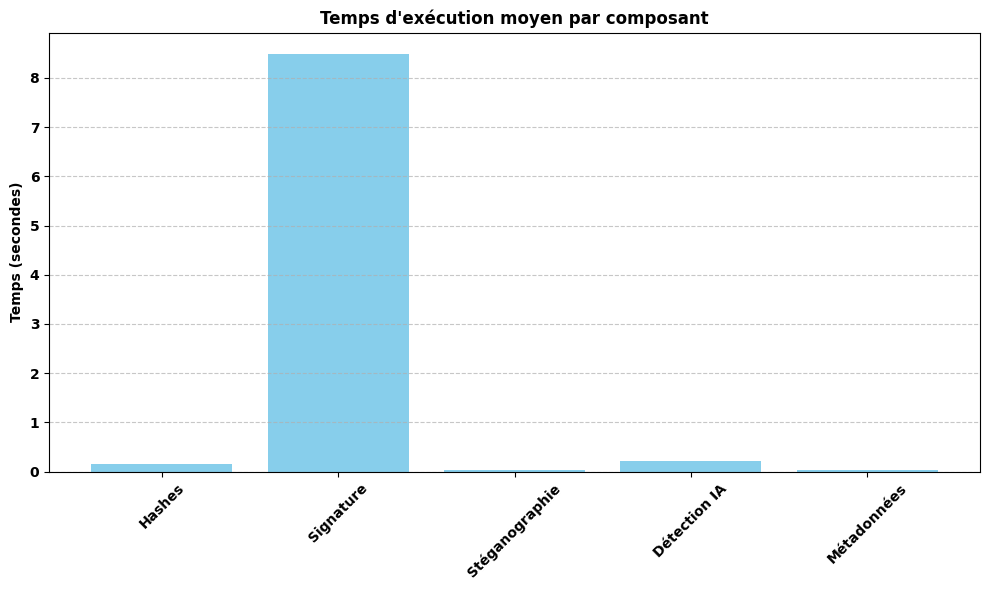

"\n# Documentation du Système de Vérification d'Images\n\n## Architecture du système\n\nLe système de vérification d'images est composé des modules suivants:\n\n1. **Génération de hashes perceptuels**\n   - Utilise pHash, dHash, wHash et aHash pour la détection de similarité\n   - Robuste aux modifications mineures (redimensionnement, compression)\n\n2. **Détection de similarité**\n   - Compare les hashes avec une base de données d'images connues\n   - Utilise la distance de Hamming pour mesurer la similarité\n\n3. **Génération de signature contextuelle**\n   - Extrait des caractéristiques d'image avec OpenCV\n   - Combine points clés, histogramme et statistiques d'image\n\n4. **Stéganographie**\n   - Insertion et détection de messages cachés dans les images\n   - Utilise la technique LSB (Least Significant Bit)\n\n5. **Extraction de métadonnées**\n   - Analyse des données EXIF et autres métadonnées d'image\n   - Détection d'anomalies dans les métadonnées\n\n6. **Détection d'images gén

In [102]:
# 16. Tests et évaluation du système

def evaluate_system_performance(test_folder=TEST_IMAGES):
    """
    Évalue les performances du système sur un ensemble d'images de test.
    """
    print("=== ÉVALUATION DES PERFORMANCES DU SYSTÈME ===")

    # Collecter toutes les images de test
    image_files = []
    for root, dirs, files in os.walk(test_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_files.append(os.path.join(root, file))

    if not image_files:
        print("Aucune image trouvée pour l'évaluation")
        return

    print(f"Évaluation sur {len(image_files)} images...")

    # Mesures de performance
    results = {
        "total_images": len(image_files),
        "success_count": 0,
        "error_count": 0,
        "avg_analysis_time": 0,
        "hash_generation_times": [],
        "signature_generation_times": [],
        "steganography_times": [],
        "ai_detection_times": [],
        "metadata_extraction_times": []
    }

    # Tester chaque image
    for img_path in image_files:
        print(f"\nAnalyse de {os.path.basename(img_path)}...")

        try:
            # Test 1: Génération de hashes
            start_time = time.time()
            hashes = generate_image_hashes(img_path)
            hash_time = time.time() - start_time
            results["hash_generation_times"].append(hash_time)

            # Test 2: Génération de signature
            start_time = time.time()
            signature = generate_image_context_signature(img_path)
            sig_time = time.time() - start_time
            results["signature_generation_times"].append(sig_time)

            # Test 3: Stéganographie
            start_time = time.time()
            steg_analysis = analyze_steganography(img_path)
            steg_time = time.time() - start_time
            results["steganography_times"].append(steg_time)

            # Test 4: Détection d'IA
            if ai_model:
                start_time = time.time()
                ai_result = detect_ai_generated_image(ai_model, img_path)
                ai_time = time.time() - start_time
                results["ai_detection_times"].append(ai_time)

            # Test 5: Extraction de métadonnées
            start_time = time.time()
            metadata = extract_image_metadata(img_path)
            meta_time = time.time() - start_time
            results["metadata_extraction_times"].append(meta_time)

            results["success_count"] += 1

        except Exception as e:
            print(f"Erreur sur {os.path.basename(img_path)}: {str(e)}")
            results["error_count"] += 1

    # Calculer les moyennes
    if results["hash_generation_times"]:
        results["avg_hash_time"] = sum(results["hash_generation_times"]) / len(results["hash_generation_times"])
    if results["signature_generation_times"]:
        results["avg_signature_time"] = sum(results["signature_generation_times"]) / len(results["signature_generation_times"])
    if results["steganography_times"]:
        results["avg_steg_time"] = sum(results["steganography_times"]) / len(results["steganography_times"])
    if results["ai_detection_times"]:
        results["avg_ai_time"] = sum(results["ai_detection_times"]) / len(results["ai_detection_times"])
    if results["metadata_extraction_times"]:
        results["avg_metadata_time"] = sum(results["metadata_extraction_times"]) / len(results["metadata_extraction_times"])

    # Afficher les résultats
    print("\n=== RÉSULTATS DE L'ÉVALUATION ===")
    print(f"Images totales analysées: {results['total_images']}")
    print(f"Analyses réussies: {results['success_count']} ({(results['success_count']/results['total_images'])*100:.1f}%)")
    print(f"Erreurs: {results['error_count']} ({(results['error_count']/results['total_images'])*100:.1f}%)")
    print("\nTemps d'exécution moyens:")

    if "avg_hash_time" in results:
        print(f"- Génération de hashes: {results['avg_hash_time']:.4f} secondes")
    if "avg_signature_time" in results:
        print(f"- Génération de signature: {results['avg_signature_time']:.4f} secondes")
    if "avg_steg_time" in results:
        print(f"- Analyse stéganographique: {results['avg_steg_time']:.4f} secondes")
    if "avg_ai_time" in results:
        print(f"- Détection d'IA: {results['avg_ai_time']:.4f} secondes")
    if "avg_metadata_time" in results:
        print(f"- Extraction métadonnées: {results['avg_metadata_time']:.4f} secondes")

    # Afficher un graphique des performances
    plt.figure(figsize=(10, 6))
    labels = []
    values = []

    if "avg_hash_time" in results:
        labels.append("Hashes")
        values.append(results["avg_hash_time"])
    if "avg_signature_time" in results:
        labels.append("Signature")
        values.append(results["avg_signature_time"])
    if "avg_steg_time" in results:
        labels.append("Stéganographie")
        values.append(results["avg_steg_time"])
    if "avg_ai_time" in results:
        labels.append("Détection IA")
        values.append(results["avg_ai_time"])
    if "avg_metadata_time" in results:
        labels.append("Métadonnées")
        values.append(results["avg_metadata_time"])

    plt.bar(labels, values, color='skyblue')
    plt.title('Temps d\'exécution moyen par composant')
    plt.ylabel('Temps (secondes)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results

# Exécuter l'évaluation du système
evaluation_results = evaluate_system_performance()


# 17. Documentation et Recommandations

"""
# Documentation du Système de Vérification d'Images

## Architecture du système

Le système de vérification d'images est composé des modules suivants:

1. **Génération de hashes perceptuels**
   - Utilise pHash, dHash, wHash et aHash pour la détection de similarité
   - Robuste aux modifications mineures (redimensionnement, compression)

2. **Détection de similarité**
   - Compare les hashes avec une base de données d'images connues
   - Utilise la distance de Hamming pour mesurer la similarité

3. **Génération de signature contextuelle**
   - Extrait des caractéristiques d'image avec OpenCV
   - Combine points clés, histogramme et statistiques d'image

4. **Stéganographie**
   - Insertion et détection de messages cachés dans les images
   - Utilise la technique LSB (Least Significant Bit)

5. **Extraction de métadonnées**
   - Analyse des données EXIF et autres métadonnées d'image
   - Détection d'anomalies dans les métadonnées

6. **Détection d'images générées par IA**
   - Utilise un modèle TensorFlow pour classifier les images

7. **Base de données PostgreSQL**
   - Stockage persistant des images et de leurs analyses
   - Indexation pour des recherches rapides

8. **Interface Web**
   - API Flask pour l'analyse d'images
   - Interface simple pour télécharger et analyser des images

## Recommandations d'amélioration

### Court terme

- Implémenter un système de cache pour les résultats d'analyse fréquents
- Ajouter une authentification pour l'API web
- Optimiser les requêtes de recherche de similarité pour de grandes bases de données

### Moyen terme

- Entraîner le modèle de détection d'IA sur plus de données
- Ajouter un support pour les formats d'image supplémentaires (WEBP, HEIC)
- Développer une interface utilisateur plus complète

### Long terme

- Intégrer des techniques de vérification basées sur la blockchain
- Ajouter la prise en charge des vidéos et des fichiers audio
- Développer un système distribué pour l'analyse à grande échelle
"""


In [82]:
# 18. Analyse approfondie d'une image exemple

def perform_detailed_analysis_example():
    """
    Réalise une analyse détaillée d'une image exemple avec visualisations.
    """
    if not test_image_paths:
        print("Aucune image de test disponible")
        return

    # Sélectionner une image pour l'analyse
    test_img = test_image_paths
    print(f"=== ANALYSE DÉTAILLÉE DE {os.path.basename(test_img)} ===")

    # 1. Afficher l'image originale
    img = cv2.imread(test_img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.title("Image Originale")
    plt.imshow(img_rgb)
    plt.axis('off')

    # 2. Extraire et afficher les caractéristiques clés
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(nfeatures=50)
    keypoints, _ = orb.detectAndCompute(gray, None)

    img_keypoints = cv2.drawKeypoints(img_rgb, keypoints, None, color=(0, 255, 0), flags=0)
    plt.subplot(2, 2, 2)
    plt.title("Points d'intérêt détectés")
    plt.imshow(img_keypoints)
    plt.axis('off')

    # 3. Afficher les contours
    edges = cv2.Canny(gray, 100, 200)
    plt.subplot(2, 2, 3)
    plt.title("Détection de contours")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')

    # 4. Afficher l'histogramme de l'image
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    plt.subplot(2, 2, 4)
    plt.title("Histogramme d'intensité")
    plt.plot(hist, color='black')
    plt.xlabel("Intensité des pixels")
    plt.ylabel("Nombre de pixels")
    plt.show()


In [83]:
perform_detailed_analysis_example()

=== ANALYSE DÉTAILLÉE DE test.png ===


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
